In [1]:
from pyspark.sql import SparkSession

# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("CellPhonesAccessoriesAnalysis") \
    .config("spark.network.timeout", "1000s") \
    .config("spark.executor.heartbeatInterval", "900s") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "9g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

In [2]:
# Step 2: Define HDFS file path
#file_path = "hdfs://localhost:9000/project/Cell_Phones_and_Accessories.jsonl"

# Step 3: Load JSONL file into Spark DataFrame
#df_spark = spark.read.json(file_path)

# Step 4: Display the schema and the first 5 rows
#print("Schema of the dataset:")
#df_spark.printSchema()
#print("\nFirst 5 rows of the dataset:")
#df_spark.show(5, truncate=False)

In [3]:
# Define the output path for the CSV
#output_path = "hdfs://localhost:9000/project/Cell_Phones_and_Accessories_selected.csv"

# Select only the required features
#required_columns = ["asin", "rating", "text", "timestamp", "verified_purchase", "title"]
#df_selected = df_spark.select(*required_columns)

# Save the selected columns to a CSV file
#df_selected.write.csv(output_path, header=True, mode="overwrite")

#print(f"CSV file with selected columns saved at: {output_path}")


In [5]:
# Define the output path for the CSV
output_path = "hdfs://localhost:9000/project/Cell_Phones_and_Accessories_selected.csv"

# Load the CSV back into a Spark DataFrame
df_csv = spark.read.csv(output_path, header=True)

# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df_csv.limit(2).toPandas()  # Use limit to restrict rows for conversion

# Display the Pandas DataFrame as a table
from IPython.display import display
display(df_pandas.style.set_table_styles(
    [{
        'selector': 'thead th',
        'props': [('text-align', 'left')]
    }]
).set_properties(**{'text-align': 'left'}))

,asin,rating,text,timestamp,verified_purchase,title
0,B08L6L3X1S,4.0,I bought this bc I thought it had the nice white background. Turns out it’s clear & since my phone is blue it doesn’t look anything like this. If I had known that I would have purchased something else. It works ok.,1612044451196,true,No white background! It’s clear!
1,B079BPGF6C,5.0,Perfect. How pissed am I that I recently paid $20 for 1 Fitbit cable and promptly lost the damned thing? Extremely pissed! I keep the spare in my medicine bag so hopefully I won’t lose it and my grandson can’t get to it and try to use it as a belt or a dog leash or any of the other nutty things he’s been using the other one for.,1534443517349,true,Awesome! Great price! Works well!


In [6]:
# Handle Missing Values
from pyspark.sql.functions import col, count, when

# Count the number of missing values in each column
print("Number of rows with missing values:")
missing_values = df_csv.select(
    [
        count(when(col(c).isNull(), c)).alias(c) for c in df_csv.columns
    ]
)

# Show the count of missing values for all columns
missing_values.show()

Number of rows with missing values:
+----+------+-----+---------+-----------------+-----+
|asin|rating| text|timestamp|verified_purchase|title|
+----+------+-----+---------+-----------------+-----+
|   0|     0|22275|        0|                0|    0|
+----+------+-----+---------+-----------------+-----+



In [7]:
# Drop all rows with missing values
df_no_missing = df_csv.dropna()

# Recalculate the number of missing values in each column after dropping rows
missing_values_after_dropping = df_no_missing.select(
    [
        count(when(col(c).isNull(), c)).alias(c) for c in df_no_missing.columns
    ]
)

# Display the updated count of missing values for all columns
print("Number of missing values after dropping rows with missing values:")
missing_values_after_dropping.show()

# Display the total number of rows remaining
print(f"Total number of rows after dropping missing values: {df_no_missing.count()}")


Number of missing values after dropping rows with missing values:
+----+------+----+---------+-----------------+-----+
|asin|rating|text|timestamp|verified_purchase|title|
+----+------+----+---------+-----------------+-----+
|   0|     0|   0|        0|                0|    0|
+----+------+----+---------+-----------------+-----+

Total number of rows after dropping missing values: 20790670


In [8]:
from pyspark.sql.types import FloatType

# Step 1: Convert 'rating' column to FloatType
df_no_missing = df_no_missing.withColumn("rating", col("rating").cast(FloatType()))

# Step 2: Compute Q1 and Q3 for the 'rating' column using approxQuantile
q1, q3 = df_no_missing.approxQuantile("rating", [0.25, 0.75], 0.01)

# Step 3: Calculate IQR (Interquartile Range)
iqr = q3 - q1

# Step 4: Calculate Lower and Upper Bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Step 5: Filter Out Rows with Outliers in 'rating'
df_no_outliers = df_no_missing.filter(
    (col("rating") >= lower_bound) & (col("rating") <= upper_bound)
)

# Step 6: Show the effect of outlier removal
print(f"Number of rows before outlier removal: {df_no_missing.count()}")
print(f"Number of rows after outlier removal: {df_no_outliers.count()}")


Lower Bound: 0.0, Upper Bound: 8.0
Number of rows before outlier removal: 20790670
Number of rows after outlier removal: 20790670


In [9]:
# Define valid timestamp range in milliseconds
min_timestamp = 946684800000  # 01-Jan-2000 in milliseconds
max_timestamp = 1704067200000  # 01-Jan-2024 in milliseconds

# Filter out rows with timestamps outside the valid range
df_filtered_timestamps = df_no_outliers.filter(
    (col("timestamp") >= min_timestamp) & (col("timestamp") <= max_timestamp)
)

print(f"Number of rows after timestamp filtering: {df_filtered_timestamps.count()}")


Number of rows after timestamp filtering: 20790667


In [12]:
from IPython.display import display, HTML
import pandas as pd
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import regexp_replace, col, lower, trim

# Step 1: Select two rows before text cleaning (convert to Pandas for display)
before_cleaning = df_filtered_timestamps.limit(2).toPandas()

# Step 2: Text Cleaning
df_cleaned = df_filtered_timestamps.withColumn(
    "text",
    regexp_replace(col("text"), "<[^>]+>", "")  # Remove HTML tags
)
df_cleaned = df_cleaned.withColumn(
    "text",
    regexp_replace(col("text"), "[^a-zA-Z0-9\s]", "")  # Remove special characters/punctuation
)
df_cleaned = df_cleaned.withColumn(
    "text",
    lower(col("text"))  # Convert to lowercase
)
df_cleaned = df_cleaned.withColumn(
    "text",
    trim(regexp_replace(col("text"), "\s+", " "))  # Remove extra whitespaces
)

# Tokenize and remove stopwords
tokenizer = Tokenizer(inputCol="text", outputCol="text_tokens")
df_tokenized = tokenizer.transform(df_cleaned)
remover = StopWordsRemover(inputCol="text_tokens", outputCol="text_cleaned")
df_cleaned = remover.transform(df_tokenized)

# Step 3: Select two rows after text cleaning
after_cleaning = df_cleaned.select("text", "text_cleaned").limit(2).toPandas()

# Step 4: Display results as a real HTML table
display(HTML("<h3>Sample Output</h3>"))

# Add CSS styling for full left alignment
table_css = """
<style>
    table {
        display: inline;
        text-align: left;
        margin-right: 20px;
    }
    th {
        text-align: left !important;
    }
    td {
        text-align: left !important;
    }
</style>
"""

# Display the CSS styles
display(HTML(table_css))

# Display the "Before Cleaning" table
display(HTML("<h4>Before Cleaning:</h4>"))
display(before_cleaning.style.set_table_attributes("style='display:inline'").set_caption("Before Cleaning"))

# Display the "After Cleaning" table
display(HTML("<h4>After Cleaning:</h4>"))
display(after_cleaning.style.set_table_attributes("style='display:inline'").set_caption("After Cleaning"))


,asin,rating,text,timestamp,verified_purchase,title
0,B08L6L3X1S,4.000000,I bought this bc I thought it had the nice white background. Turns out it’s clear & since my phone is blue it doesn’t look anything like this. If I had known that I would have purchased something else. It works ok.,1612044451196,true,No white background! It’s clear!
1,B079BPGF6C,5.000000,Perfect. How pissed am I that I recently paid $20 for 1 Fitbit cable and promptly lost the damned thing? Extremely pissed! I keep the spare in my medicine bag so hopefully I won’t lose it and my grandson can’t get to it and try to use it as a belt or a dog leash or any of the other nutty things he’s been using the other one for.,1534443517349,true,Awesome! Great price! Works well!


,text,text_cleaned
0,i bought this bc i thought it had the nice white background turns out its clear since my phone is blue it doesnt look anything like this if i had known that i would have purchased something else it works ok,"['bought', 'bc', 'thought', 'nice', 'white', 'background', 'turns', 'clear', 'since', 'phone', 'blue', 'doesnt', 'look', 'anything', 'like', 'known', 'purchased', 'something', 'else', 'works', 'ok']"
1,perfect how pissed am i that i recently paid 20 for 1 fitbit cable and promptly lost the damned thing extremely pissed i keep the spare in my medicine bag so hopefully i wont lose it and my grandson cant get to it and try to use it as a belt or a dog leash or any of the other nutty things hes been using the other one for,"['perfect', 'pissed', 'recently', 'paid', '20', '1', 'fitbit', 'cable', 'promptly', 'lost', 'damned', 'thing', 'extremely', 'pissed', 'keep', 'spare', 'medicine', 'bag', 'hopefully', 'wont', 'lose', 'grandson', 'cant', 'get', 'try', 'use', 'belt', 'dog', 'leash', 'nutty', 'things', 'hes', 'using', 'one']"


In [13]:
from pyspark.sql.functions import when

# Generate sentiment labels based on rating
df_sentiment = df_cleaned.withColumn(
    "sentiment",
    when(col("rating") >= 4, "positive")
    .when(col("rating") == 3, "neutral")
    .otherwise("negative")
)

# Display the first few rows with sentiment labels
df_sentiment.select("text_cleaned", "rating", "sentiment").show(truncate=True)


+--------------------+------+---------+
|        text_cleaned|rating|sentiment|
+--------------------+------+---------+
|[bought, bc, thou...|   4.0| positive|
|[perfect, pissed,...|   5.0| positive|
|[overall, happy, ...|   5.0| positive|
|[lasted, 9, month...|   4.0| positive|
|[love, case, work...|   5.0| positive|
|[item, works, gre...|   5.0| positive|
|[item, came, desc...|   5.0| positive|
|[stocking, stuffe...|   4.0| positive|
|[son, loves, camo...|   5.0| positive|
|[work, little, di...|   5.0| positive|
|[really, work, li...|   5.0| positive|
|[big, phones, har...|   5.0| positive|
|[works, great, lo...|   5.0| positive|
|[people, given, l...|   5.0| positive|
|[great, fit, love...|   4.0| positive|
|[hard, separate, ...|   3.0|  neutral|
|[putting, night, ...|   2.0| negative|
|[weve, survived, ...|   5.0| positive|
|[got, wife, loves...|   5.0| positive|
|[went, perfect, c...|   5.0| positive|
+--------------------+------+---------+
only showing top 20 rows



In [14]:
from pyspark.sql.functions import col, format_number
from IPython.display import display, HTML
import pandas as pd

# Step 1: Format the 'rating' column to 1 decimal digit
df_sentiment = df_sentiment.withColumn("rating", format_number(col("rating").cast("float"), 1))

# Step 2: Select 2 random rows and convert to Pandas for display
random_rows = (
    df_sentiment.select(
        col("text"), 
        col("text_cleaned"), 
        col("rating"), 
        col("sentiment")
    )
    .orderBy(col("rating").desc())  # Order by highest rating
    .limit(2)  # Limit to 2 rows
    .toPandas()
)

# Step 3: Ensure unique index and clean column names
random_rows.reset_index(drop=True, inplace=True)  # Ensure the index is unique
random_rows.columns = [col.strip() for col in random_rows.columns]  # Clean column names

# Step 4: Style the Pandas DataFrame for better display
# Convert text_cleaned column to lists for proper display
if "text_cleaned" in random_rows.columns:
    random_rows["text_cleaned"] = random_rows["text_cleaned"].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Display the table with a title
display(HTML("<h3 style='text-align: left;'>Sample Sentiment Labeled Data</h3>"))
display(
    random_rows.style.set_table_attributes("style='display:inline; text-align:left'")
    .set_caption("<p style='text-align: left;'>2 Random Rows with Sentiment Labeling</p>")
    .set_properties(**{"text-align": "left"})
)


,text,text_cleaned,rating,sentiment
0,omgill make this short and sweetif you want the ultimate case to keep your 500 dollar phone safebuy this right now this is seriously some kind of next level hardcore techtook me less than 5 minutes to install this is worth 4 times the price shipping was light speedbest purchase ive made in a long timethe only question you need to ask is what color do i want i went with red,"['omgill', 'make', 'short', 'sweetif', 'want', 'ultimate', 'case', 'keep', '500', 'dollar', 'phone', 'safebuy', 'right', 'seriously', 'kind', 'next', 'level', 'hardcore', 'techtook', 'less', '5', 'minutes', 'install', 'worth', '4', 'times', 'price', 'shipping', 'light', 'speedbest', 'purchase', 'ive', 'made', 'long', 'timethe', 'question', 'need', 'ask', 'color', 'want', 'went', 'red']",5.0,positive
1,perfect case for my a71 4g i dont think it will fit 5g strong seems durabletime will tell highly recommend as i couldnt find a good case in my town buy it u wont regret,"['perfect', 'case', 'a71', '4g', 'dont', 'think', 'fit', '5g', 'strong', 'seems', 'durabletime', 'tell', 'highly', 'recommend', 'couldnt', 'find', 'good', 'case', 'town', 'buy', 'u', 'wont', 'regret']",5.0,positive


In [15]:
from pyspark.sql.functions import when, col

# Step 1: Define Categories Based on Keywords in Both Title and Text
df_categorized = df_sentiment.withColumn(
    "category",
    when(
        col("title").rlike(
            "(?i)(iPhone|iphone|ipone|ihone|iphnoe|iphoen|uPhone|jPhone|oPhone|iphine|iphoone|iiphone|ipphone|ifone|iphon \
            |ifon|i-Phone|i phone|iPad|ipad|ipd|iad|ipda|iapd|uPad|oPad|iPas|iPaf|iPadd|ipadd|i-pad|Apple|apple|aple|appl \
            |appel|aplpe|spple|aqple|apole|appple|applee|ap-ple|Aple)"
        )
        | col("text").rlike(
            "(?i)(iPhone|iphone|ipone|ihone|iphnoe|iphoen|uPhone|jPhone|oPhone|iphine|iphoone|iiphone|ipphone|ifone|iphon \
            |ifon|i-Phone|i phone|iPad|ipad|ipd|iad|ipda|iapd|uPad|oPad|iPas|iPaf|iPadd|ipadd|i-pad|Apple|apple|aple|appl \
            |appel|aplpe|spple|aqple|apole|appple|applee|ap-ple|Aple)"
        ),
        "iOS",
    )
    .when(
        col("title").rlike(
            "(?i)(android|andriod|anroid|androiid|andorid|amdroid|andr0id|samsung|samusng|samgsung|sansung|samsong|sammsung \
            |sam-sung|galaxy|galaxi|galaxyy|gallaxy|galixy|galxy|pixel|pixle|pixal|pizel|pixell|pixcel|pix-el|oneplus|one-plus \
            |one pluss|oneplus|onepluss|one pluss|xiaomi|xaiomi|xiomi|xioami|xiaomii|xiaomie|x-iaomi)"
        )
        | col("text").rlike(
            "(?i)(android|andriod|anroid|androiid|andorid|amdroid|andr0id|samsung|samusng|samgsung|sansung|samsong|sammsung \
            |sam-sung|galaxy|galaxi|galaxyy|gallaxy|galixy|galxy|pixel|pixle|pixal|pizel|pixell|pixcel|pix-el|oneplus|one-plus \
            |one pluss|oneplus|onepluss|one pluss|xiaomi|xaiomi|xiomi|xioami|xiaomii|xiaomie|x-iaomi)"
        ),
        "Android",
    )
)

# Step 2: Filter Out Rows Without a Category
df_categorized = df_categorized.filter(col("category").isNotNull())

# Step 3: Display the Categorized Data
df_categorized.select("title", "text", "category", "rating", "sentiment").show(truncate=True)

# Step 4: Validate Distribution of Categories
category_distribution = df_categorized.groupBy("category").count()

# Display the counts
print("Category Distribution:")
category_distribution.show()


+--------------------+--------------------+--------+------+---------+
|               title|                text|category|rating|sentiment|
+--------------------+--------------------+--------+------+---------+
|Worked but took a...|overall very happ...|     iOS|   5.0| positive|
|Works Great with ...|this item works g...|     iOS|   5.0| positive|
|A bit complicated...|a bit complicated...|     iOS|   2.0| negative|
|            One Star|fell apart right ...|     iOS|   1.0| negative|
|So frustrating, n...|i had one that la...|     iOS|   2.0| negative|
|  Renewed Perfection|i bought a renewe...|     iOS|   5.0| positive|
|Nice texture and ...|very happy with t...| Android|   5.0| positive|
|Too cheap for suc...|i had this same c...| Android|   2.0| negative|
|             Caution|was difficult to ...|     iOS|   2.0| negative|
|              Pretty|better than expec...|     iOS|   5.0| positive|
|   Well, it’s a case|this is a thin ch...|     iOS|   2.0| negative|
|          Great ide

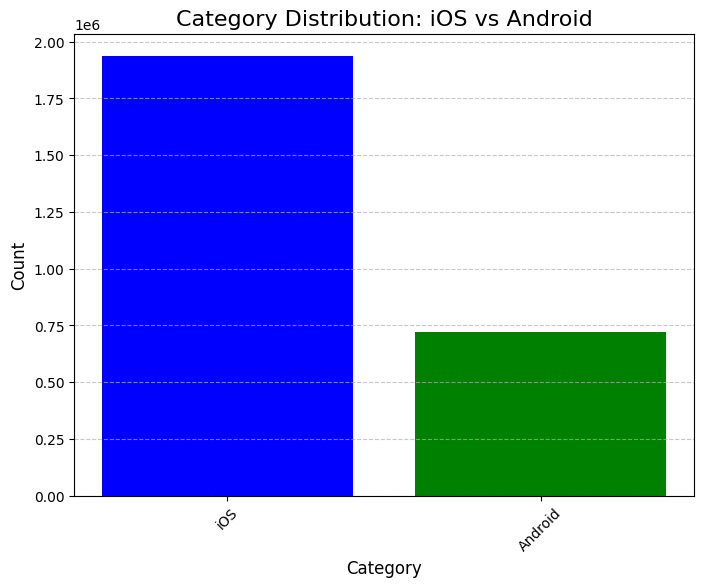

In [16]:
# Convert the category distribution to a Pandas DataFrame for plotting
category_distribution_pandas = category_distribution.toPandas()

# Plot the distribution as a bar chart
import matplotlib.pyplot as plt
from IPython.display import display

# Set up the plot
plt.figure(figsize=(8, 6))
plt.bar(
    category_distribution_pandas["category"],
    category_distribution_pandas["count"],
    color=["blue", "green"]
)
plt.title("Category Distribution: iOS vs Android", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.show()


In [18]:
df_categorized.select("title", "text", "text_cleaned", "rating", "sentiment", "category").show(20, truncate=True)

+--------------------+--------------------+--------------------+------+---------+--------+
|               title|                text|        text_cleaned|rating|sentiment|category|
+--------------------+--------------------+--------------------+------+---------+--------+
|Worked but took a...|overall very happ...|[overall, happy, ...|   5.0| positive|     iOS|
|Works Great with ...|this item works g...|[item, works, gre...|   5.0| positive|     iOS|
|A bit complicated...|a bit complicated...|[bit, complicated...|   2.0| negative|     iOS|
|            One Star|fell apart right ...|[fell, apart, rig...|   1.0| negative|     iOS|
|So frustrating, n...|i had one that la...|[one, lasted, yea...|   2.0| negative|     iOS|
|  Renewed Perfection|i bought a renewe...|[bought, renewed,...|   5.0| positive|     iOS|
|Nice texture and ...|very happy with t...|[happy, case, tri...|   5.0| positive| Android|
|Too cheap for suc...|i had this same c...|[case, pixel, 3, ...|   2.0| negative| Android|

In [19]:
from pyspark.sql.functions import col, count, lit, first, round

# Step 1: Calculate total count per category
total_counts = df_categorized.groupBy("category").count().withColumnRenamed("count", "total_count")

# Step 2: Calculate sentiment counts per category
sentiment_counts = df_categorized.groupBy("category", "sentiment").count()

# Step 3: Join sentiment counts with total counts to calculate percentages
sentiment_percentages = sentiment_counts.join(
    total_counts, on="category"
).withColumn(
    "percentage", round((col("count") / col("total_count") * 100), 2)  # Round to 2 decimal places
)

# Cache the intermediate result to avoid recomputation
sentiment_percentages.cache()
sentiment_percentages.count()  # Trigger the cache

# Step 4: Pivot the table to make it easier to visualize later
sentiment_distribution = sentiment_percentages.groupBy("category").pivot("sentiment").agg(
    first("percentage")
)

# Cache the pivoted DataFrame for plotting or reuse
sentiment_distribution.cache()
sentiment_distribution.count()  # Trigger the cache

# Step 5: Display the result
sentiment_distribution.show()


+--------+--------+-------+--------+
|category|negative|neutral|positive|
+--------+--------+-------+--------+
|     iOS|   17.72|   6.42|   75.86|
| Android|   22.17|   7.36|   70.47|
+--------+--------+-------+--------+



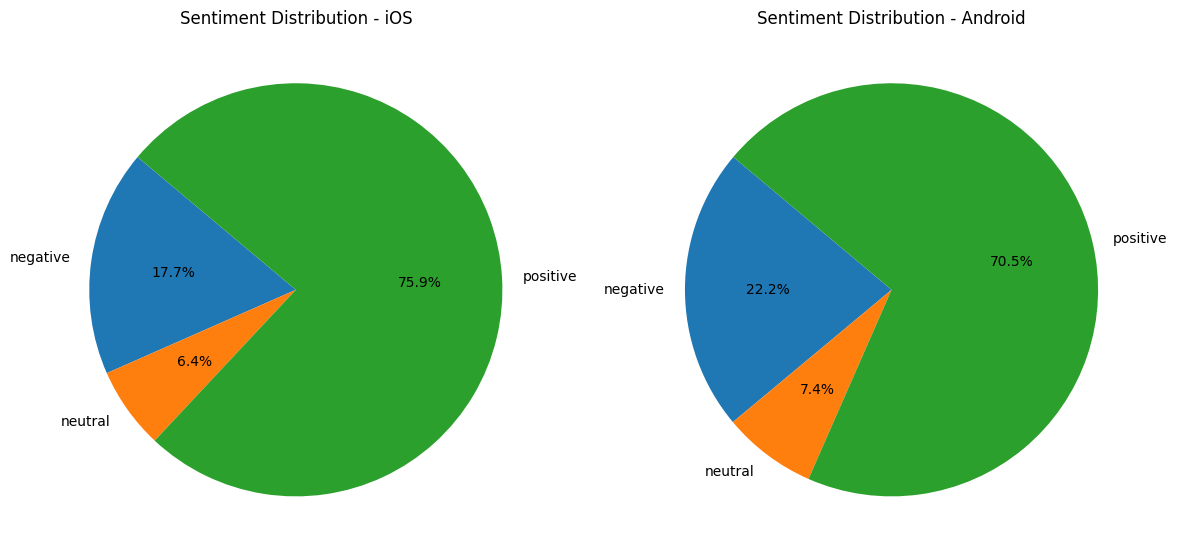

In [20]:
import matplotlib.pyplot as plt

# Convert the cached Spark DataFrame to Pandas
sentiment_distribution_pandas = sentiment_distribution.toPandas()

# Fill NaN with 0 for visualization purposes
sentiment_distribution_pandas = sentiment_distribution_pandas.fillna(0)

# Extracting data for the two categories (e.g., iOS and Android)
ios_data = sentiment_distribution_pandas[sentiment_distribution_pandas['category'] == 'iOS']
android_data = sentiment_distribution_pandas[sentiment_distribution_pandas['category'] == 'Android']

# Preparing data for pie charts
ios_labels = ios_data.columns[1:]  # Exclude 'category'
ios_values = ios_data.iloc[0, 1:].values  # Corresponding percentages

android_labels = android_data.columns[1:]  # Exclude 'category'
android_values = android_data.iloc[0, 1:].values  # Corresponding percentages

# Plotting the pie charts
plt.figure(figsize=(12, 6))

# iOS Pie Chart
plt.subplot(1, 2, 1)
plt.pie(ios_values, labels=ios_labels, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution - iOS')

# Android Pie Chart
plt.subplot(1, 2, 2)
plt.pie(android_values, labels=android_labels, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution - Android')

# Display the plots
plt.tight_layout()
plt.show()


In [21]:
from pyspark.sql.functions import from_unixtime, year, avg, round
from datetime import datetime

# Step 1: Convert timestamp to year
df_categorized = df_categorized.withColumn("year", year(from_unixtime(col("timestamp") / 1000)))

# Step 2: Filter data for the last 5 years
current_year = datetime.now().year
df_categorized_last_5_years = df_categorized.filter(col("year") >= (current_year - 5))

# Step 3: Filter for iOS and Android categories
df_ios = df_categorized_last_5_years.filter(col("category") == "iOS")
df_android = df_categorized_last_5_years.filter(col("category") == "Android")

# Step 4: Calculate average ratings by year for iOS and round to 2 decimal places
avg_ratings_ios = df_ios.groupBy("year").agg(
    round(avg(col("rating").cast("float")), 2).alias("avg_rating_ios")
).orderBy("year")

# Step 5: Calculate average ratings by year for Android and round to 2 decimal places
avg_ratings_android = df_android.groupBy("year").agg(
    round(avg(col("rating").cast("float")), 2).alias("avg_rating_android")
).orderBy("year")

# Step 6: Join the results for comparison
avg_ratings_over_time = avg_ratings_ios.join(avg_ratings_android, on="year", how="outer").orderBy("year")

# Step 7: Cache the result for reuse
avg_ratings_over_time.cache()
avg_ratings_over_time.count()  # Trigger the cache

# Step 8: Display the result
avg_ratings_over_time.show(truncate=False)


+----+--------------+------------------+
|year|avg_rating_ios|avg_rating_android|
+----+--------------+------------------+
|2019|4.2           |3.99              |
|2020|4.17          |3.94              |
|2021|4.08          |3.81              |
|2022|4.03          |3.79              |
|2023|4.13          |3.9               |
+----+--------------+------------------+



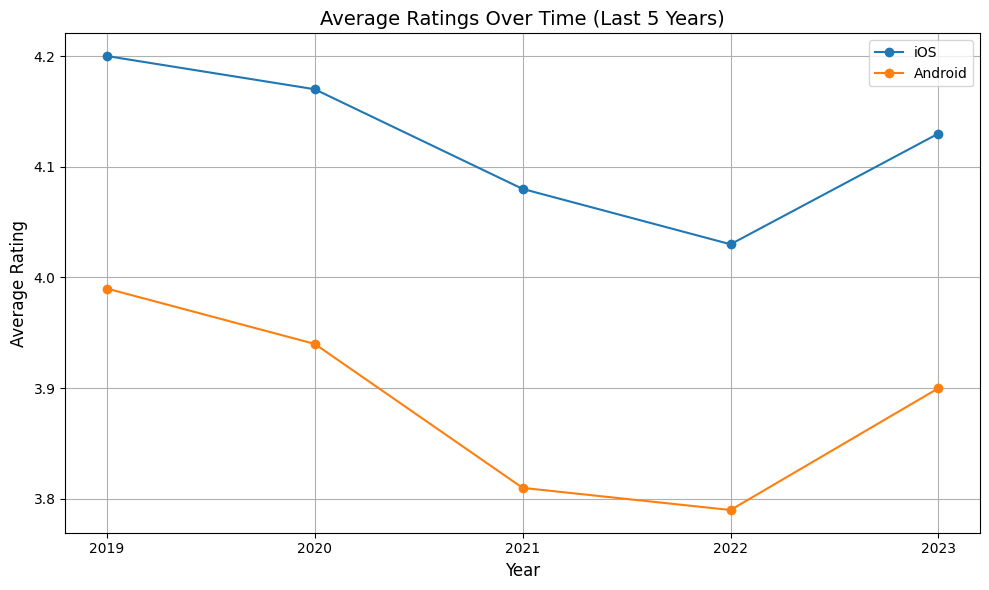

In [23]:
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to Pandas for visualization
avg_ratings_over_time_pandas = avg_ratings_over_time.toPandas()

# Fill NaN values with 0 for visualization purposes
avg_ratings_over_time_pandas = avg_ratings_over_time_pandas.fillna(0)

# Ensure year is treated as integers
avg_ratings_over_time_pandas["year"] = avg_ratings_over_time_pandas["year"].astype(int)

# Plotting the average ratings over time for iOS and Android
plt.figure(figsize=(10, 6))

# Plot iOS ratings
plt.plot(
    avg_ratings_over_time_pandas["year"],
    avg_ratings_over_time_pandas["avg_rating_ios"],
    marker='o',
    label="iOS"
)

# Plot Android ratings
plt.plot(
    avg_ratings_over_time_pandas["year"],
    avg_ratings_over_time_pandas["avg_rating_android"],
    marker='o',
    label="Android"
)

# Adding titles and labels
plt.title("Average Ratings Over Time (Last 5 Years)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.xticks(avg_ratings_over_time_pandas["year"])  # Set x-axis ticks to years
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [24]:
# pip install wordcloud

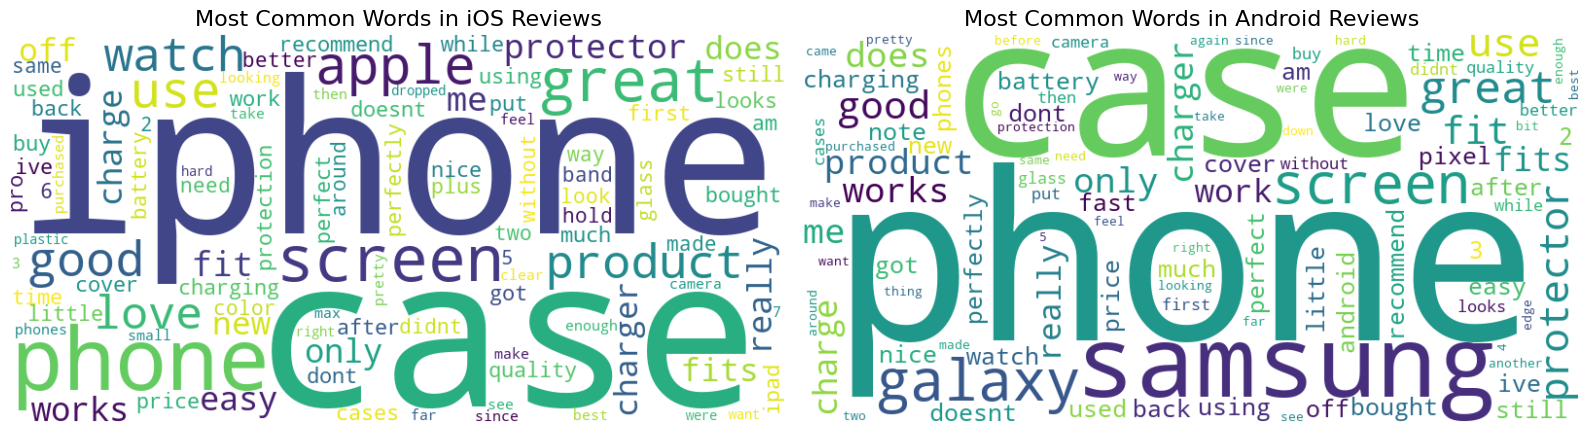

In [25]:
from pyspark.sql.functions import explode, split, lower, col
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Step 1: Tokenize the text (split by whitespace, convert to lowercase)
df_ios_tokens = df_categorized.filter(col("category") == "iOS").select(
    explode(split(lower(col("text")), r"\s+")).alias("word")
)

df_android_tokens = df_categorized.filter(col("category") == "Android").select(
    explode(split(lower(col("text")), r"\s+")).alias("word")
)

# Step 2: Remove stopwords
# Expanded stopword list based on the provided word clouds
stopwords = set([
    "the", "and", "is", "to", "of", "in", "for", "a", "on", "it", "with", "this", "at", "by",
    "my", "i", "that", "you", "was", "not", "so", "but", "have", "are", "when", "can", "from",
    "like", "will", "all", "about", "just", "be", "do", "no", "im", "they", "as", "too", "if",
    "get", "an", "what", "how", "because", "which", "their", "one", "would", "had", "out",
    "up", "its", "very", "did", "we", "now", "also", "has", "more", "or", "than", "some", 
    "even", "well", "into", "been", "them", "who", "there", "your", "her", "him", "she", 
    "he", "itself", "other", "could", "these", "such", "any", "few", "over"
])
df_ios_tokens = df_ios_tokens.filter(~col("word").isin(*stopwords))
df_android_tokens = df_android_tokens.filter(~col("word").isin(*stopwords))

# Step 3: Count word frequencies
ios_word_counts = df_ios_tokens.groupBy("word").count().orderBy(col("count").desc())
android_word_counts = df_android_tokens.groupBy("word").count().orderBy(col("count").desc())

# Cache the results for reuse
ios_word_counts.cache()
android_word_counts.cache()
ios_word_counts.count()  # Trigger cache
android_word_counts.count()  # Trigger cache

# Step 4: Convert to Pandas for WordCloud generation
ios_word_counts_pandas = ios_word_counts.limit(100).toPandas()  # Limit to top 100 words
android_word_counts_pandas = android_word_counts.limit(100).toPandas()

# Step 5: Generate WordCloud for iOS
ios_wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(
    dict(zip(ios_word_counts_pandas["word"], ios_word_counts_pandas["count"]))
)

# Step 6: Generate WordCloud for Android
android_wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(
    dict(zip(android_word_counts_pandas["word"], android_word_counts_pandas["count"]))
)

# Step 7: Plot the WordClouds
plt.figure(figsize=(16, 8))

# iOS WordCloud
plt.subplot(1, 2, 1)
plt.imshow(ios_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in iOS Reviews", fontsize=16)

# Android WordCloud
plt.subplot(1, 2, 2)
plt.imshow(android_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Android Reviews", fontsize=16)

# Display the plots
plt.tight_layout()
plt.show()
